## IDSF Machine learning using TON_IoT dataset
Import data set from csv file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

filename='Train_Test_Network.csv'
df = pd.read_csv(filename,na_values='-',low_memory=False)
df.head(5)


,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,1554198358,3.122.49.24,1883,192.168.1.152,52976,tcp,NaN,80549.530260,1762852,41933215,...,0,0,NaN,NaN,NaN,bad_TCP_checksum,NaN,F,0,normal
1,1554198358,192.168.1.79,47260,192.168.1.255,15600,udp,NaN,0.000000,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,normal
2,1554198359,192.168.1.152,1880,192.168.1.152,51782,tcp,NaN,0.000000,0,0,...,0,0,NaN,NaN,NaN,bad_TCP_checksum,NaN,F,0,normal
3,1554198359,192.168.1.152,34296,192.168.1.152,10502,tcp,NaN,0.000000,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,normal
4,1554198362,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,...,0,0,NaN,NaN,NaN,bad_UDP_checksum,NaN,F,0,normal


## Explore dataset:
* list of feature
* number of unique value in each feature

TODO: conclude which feature would be use

In [2]:
colnames = list(df.columns)
print(colnames)

print()
for i in range(len(colnames)):
    print(i,' ',colnames[i],' : ')
    print(df[colnames[i]].value_counts())
    print()

['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'label', 'type']

0   ts  : 
1556423502    1194
1556340865     976
1556423501     953
1556423638     934
1556340867     776
              ... 
1554283049       1
1554283045       1
1554283044       1
1554283043       1
1556436603       1
Name: ts, Length: 115666, dtype: int64

1   src_ip  : 
192.168.1.190     77033
192.168.1.152     67784
192.168.1.30      61637
192.

## Data preparation

Drop ts, query, uri column
Drop IPv6
Convert IPv4 to 4 number column
Simplify http_user_agent

Dummy encoding (category feature)

Minmax scaling numerical feature

In [3]:
drop_cols = ['ts','dns_query','ssl_subject','ssl_issuer','http_uri']
df.drop(drop_cols,axis=1,inplace=True)

# need process 
# src_ip    dst_ip      http_user_agent

df.drop(df[df['src_ip'].map(lambda x:':' in x )].index,inplace=True)
df.drop(df[df['dst_ip'].map(lambda x:':' in x )].index,inplace=True)

src_ip_cols = ['src_ip1','src_ip2','src_ip3','src_ip4']
dst_ip_cols = ['dst_ip1','dst_ip2','dst_ip3','dst_ip4']

df[['src_ip1','src_ip2','src_ip3','src_ip4']] = df['src_ip'].str.split('.',expand=True)
df[['dst_ip1','dst_ip2','dst_ip3','dst_ip4']] = df['dst_ip'].str.split('.',expand=True)
df['http_user_agent'] = df['http_user_agent'].str.split().str[0]

df.drop(['src_ip','dst_ip'],axis=1,inplace=True)

# dummy encoding

nomial_cols = [  'proto','service','conn_state','dns_qclass','dns_qtype','dns_rcode','dns_AA','dns_RD','dns_RA','dns_rejected',
                'ssl_version','ssl_cipher','ssl_resumed','ssl_established','http_trans_depth','http_method','http_status_code',
                'http_orig_mime_types','http_resp_mime_types','weird_name','weird_addl','http_version','weird_notice','http_user_agent']

for col in nomial_cols:
      indicators = pd.get_dummies(df[col], prefix=col, dtype=np.float64)
      df = pd.concat([df,indicators],axis=1)

df.drop(nomial_cols,axis=1,inplace=True)

# Minmax scaling

numeric_cols = ['src_port','dst_port','duration','src_bytes','dst_bytes','missed_bytes','src_pkts','src_ip_bytes',
                'dst_pkts','dst_ip_bytes','http_request_body_len','http_response_body_len',
                'src_ip1','src_ip2','src_ip3','src_ip4','dst_ip1','dst_ip2','dst_ip3','dst_ip4']

for col in numeric_cols:
      df[col] = pd.to_numeric(df[col], errors='coerce')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])




## Split dataset to train and test 
Train   : 80%
Test    : 20%

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

train_X = train.drop(['label', 'type'], axis=1)
train_Y = train['type']

test_X = test.drop(['label', 'type'], axis=1)
test_Y = test['type']


#### Visualise the distribution of dataset

<AxesSubplot:>

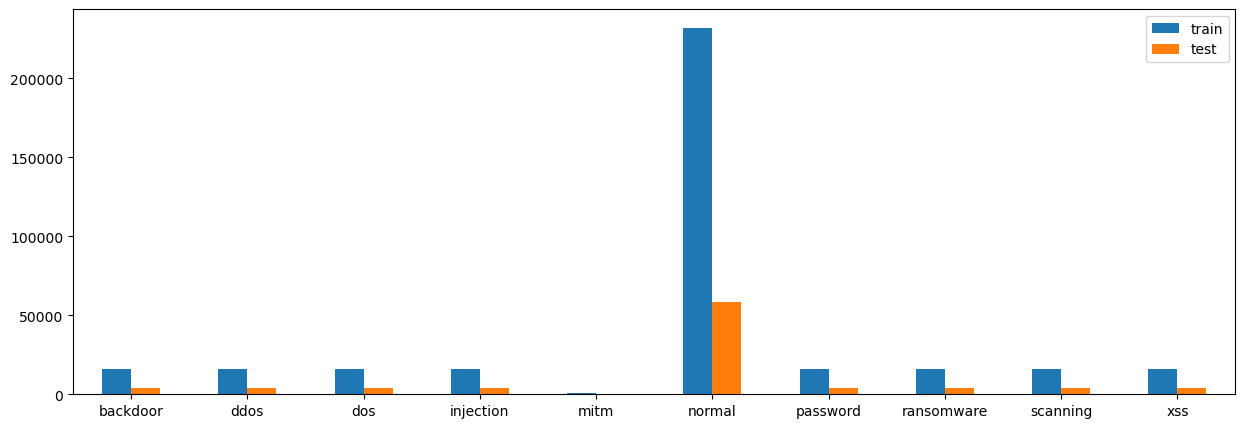

In [5]:
pd.DataFrame({
  'train': train['type'].value_counts(),
  'test': test['type'].value_counts()
}).plot.bar(figsize=(15, 5), rot=0)

<AxesSubplot:>

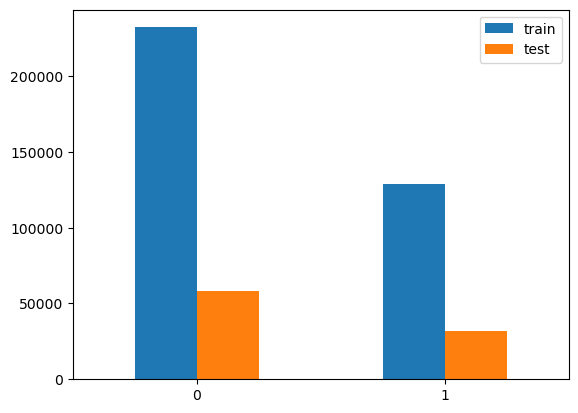

In [6]:
pd.DataFrame({
  'train': train['label'].value_counts(),
  'test': test['label'].value_counts()},
  ).plot.bar(rot=0)

<AxesSubplot:>

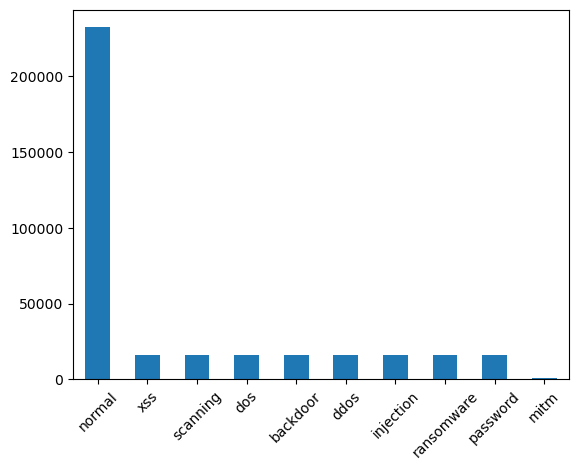

In [16]:
train_Y.value_counts().plot.bar(rot=45)

TODO: random forest for feature selection

Correlation matrix

model selection variance bias tradeoff cross validation


In [7]:
covariance_matrix = train_X.cov()
correlation_matrix = train_X.corr()
# high_cov_matrix = (covariance_matrix > 0.9) & (pd.DataFrame(np.identity(len(covariance_matrix)), index=covariance_matrix.index, columns=covariance_matrix.columns) == 0)
# covariance_matrix[~high_cov_matrix] = ""
# covariance_matrix[high_cov_matrix.any()][covariance_matrix.columns[high_cov_matrix.any(axis=1)]]


In [8]:
labels = train_Y.unique()
labels

array(['normal', 'password', 'injection', 'backdoor', 'ddos', 'scanning',
       'dos', 'xss', 'ransomware', 'mitm'], dtype=object)

# Try SVM without cross-validation

In [9]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=.1, dual=False, max_iter=10000)
svm_model.fit(train_X, train_Y)

svm_preds = svm_model.predict(train_X)
svm_accuracy = metrics.accuracy_score(train_Y, svm_preds)
svm_accuracy

0.944124087490207

In [10]:
svm_test_preds = svm_model.predict(test_X)
svm_test_accuracy = metrics.accuracy_score(test_Y, svm_test_preds)
svm_test_accuracy

0.9429507906276299

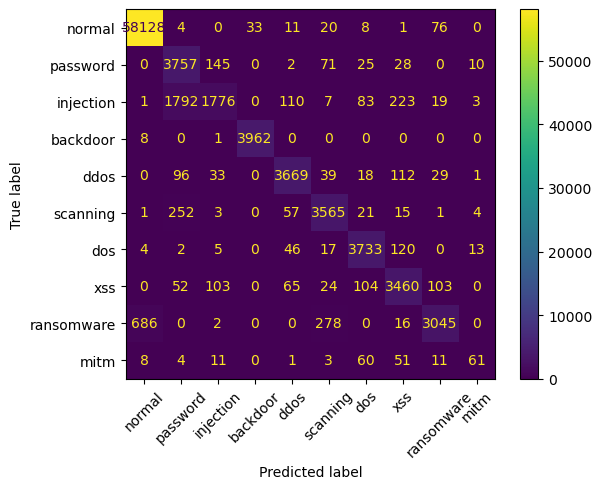

In [19]:
conf_matrix = metrics.confusion_matrix(test_Y, svm_test_preds, labels=labels)
metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels).plot(xticks_rotation=45)

# Classification

In [21]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier(loss='log')
sgd_model.fit(train_X, train_Y)

SGDClassifier(loss='log')

In [22]:
sgd_train_preds = sgd_model.predict(train_X)
sgd_train_accuracy = metrics.accuracy_score(train_Y, sgd_train_preds)
sgd_train_accuracy

0.9387479964233215

In [23]:
sgd_test_preds = sgd_model.predict(test_X)
sgd_test_accuracy = metrics.accuracy_score(test_Y, sgd_test_preds)
sgd_test_accuracy

0.9375359879523408